1. Latent Dirichlet Allocation (LDA): This is a topic modeling method that represents each document as a mixture of latent topics, where each topic is represented as a probability distribution over words. LDA can be used to discover the underlying topics that are present in a corpus of documents, as well as to represent documents in a low-dimensional topic space.

2. Convolutional Neural Networks (CNNs): This is a deep learning method that can be used to extract features from texts. CNNs can be trained to learn filters that can identify specific features in texts, such as n-grams or parts of speech. The resulting feature vectors can be used for various downstream tasks, such as classification or sentiment analysis.

# Imports

In [4]:
import re
import typing
import random
import math
import sklearn.datasets
import sklearn.preprocessing
import sklearn.metrics
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import os
import os.path
from tensorflow import keras
import dataclasses
import csv
import gensim
import gensim.corpora
import gensim.downloader
import gensim.test.utils
import itertools
from pprint import pprint

# Data

## Iris

In [5]:
iris = sklearn.datasets.load_iris()
iris_data = iris["data"]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(iris_data)
iris_data = scaler.transform(iris_data)

## Reviews

In [9]:
reviews_data = {
    "text": [],
    "sentiment": [],
}
with open("./data/reviews_mixed.csv") as f:
    f = csv.reader(f)
    header = next(f)
    for text in f:
        idk = text[0]
        idk = idk.lower()
        idk = re.sub("[.,!:;\\(\\)\"?\\-+]", " ", idk)
        idk = idk.split()
        
        reviews_data["text"].append(idk)
        
        sentiment = None
        if text[1] == "negative":
            sentiment = 0
        else:
            sentiment = 1
        if sentiment is None:
            assert False
        reviews_data["sentiment"].append(sentiment)
    
    reviews_data["sentiment"] = np.array(reviews_data["sentiment"])

# Solution

In [10]:
def nearest_neighbor(centroids: np.ndarray, data: np.ndarray) -> np.ndarray:
    closest_centroid_index = np.zeros(data.shape[0], dtype=int)
    for row_index in range(data.shape[0]):
        row = data[row_index]
        distances = [
            (centroid_index, np.sum((row - centroids[centroid_index]) ** 2))
            for centroid_index in range(centroids.shape[0])
        ]
        # print(distances)
        min_distance = min(distances, key=lambda a: a[1])
        closest_centroid_index[row_index] = min_distance[0]
    return closest_centroid_index

def kmeans(k: int, data: np.ndarray, *, centroids_init: np.ndarray = None):
    assert len(data.shape) == 2
    
    if centroids_init is not None:
        centroids = centroids_init
    else:
        centroid_indices = np.random.choice(data.shape[0], k, False)
        centroids = data[centroid_indices]
    centroid_distances = None
    loops = 0
    
    while (
        loops < 1000
        and
        (
            centroid_distances is None
            or
            np.any(centroid_distances > 0.1)
        )
    ):
        closest_centroid_index = nearest_neighbor(centroids, data)
        
        centroid_distances = np.zeros(centroids.shape[0])
        for centroid_index in range(centroids.shape[0]):
            mask = (closest_centroid_index == centroid_index)
            
            neighbors_count = np.sum(mask)
            # print(centroid_index, neighbors_count)
            if neighbors_count == 0:
                continue
            neighbors_sum = np.sum(data[mask], axis=0)
            # print(neighbors_sum)
            
            centroid = neighbors_sum / neighbors_count
            centroid_distances[centroid_index] = np.sqrt(np.sum((centroid - centroids[centroid_index]) ** 2))
            centroids[centroid_index] = centroid
        
        
        loops += 1
    
    # print(centroid_distances)
    # print(loops)
        
    return centroids

## Simple KMeans (Iris)

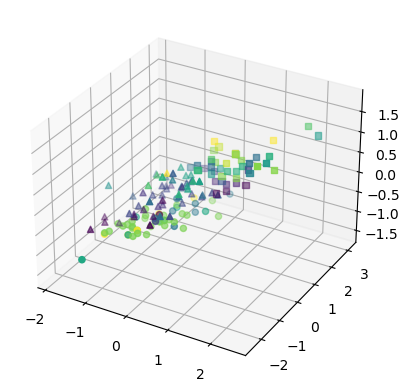

In [11]:
centroids = kmeans(3, iris_data)
centroid_indices = nearest_neighbor(centroids, iris_data)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for centroid_index, marker in [(0, "o"), (1, "^"), (2, "s")]:
    mask = centroid_indices == centroid_index
    ax.scatter(
        iris_data[mask,0],
        iris_data[mask,1],
        iris_data[mask,2],
        c = iris_data[mask,3] / np.max(iris_data[mask,3]),
        marker = marker,
)

## Extragere caracteristici

### Wrd2Vec (Reviews)

In [16]:
model = gensim.models.Word2Vec(
    sentences=reviews_data["text"],
    vector_size=10,
    window=5,
    min_count=1,
    workers=4,
)
print(model.wv["door"])

[ 0.0026725  -0.09403419 -0.08155295  0.03036398 -0.07941239 -0.09365191
 -0.01349265 -0.0713892  -0.08145922 -0.09113636]


### Latent Dirichlet Allocation (Reviews)

In [13]:
dictionary = gensim.corpora.Dictionary(reviews_data["text"])

model = gensim.models.LdaMulticore(
    [dictionary.doc2bow(row) for row in reviews_data["text"]],
    id2word=dictionary,
    num_topics=5,
)

pprint(model.print_topics())

[(0,
  '0.028*"the" + 0.023*"and" + 0.019*"room" + 0.018*"was" + 0.015*"no" + '
  '0.014*"for" + 0.013*"very" + 0.013*"some" + 0.012*"were" + 0.012*"a"'),
 (1,
  '0.057*"the" + 0.040*"was" + 0.029*"to" + 0.022*"it" + 0.018*"and" + '
  '0.011*"in" + 0.011*"room" + 0.009*"be" + 0.009*"had" + 0.008*"shower"'),
 (2,
  '0.054*"the" + 0.039*"was" + 0.035*"room" + 0.026*"and" + 0.021*"very" + '
  '0.017*"in" + 0.017*"clean" + 0.014*"a" + 0.013*"of" + 0.013*"to"'),
 (3,
  '0.044*"the" + 0.030*"room" + 0.028*"was" + 0.025*"and" + 0.020*"bed" + '
  '0.018*"very" + 0.015*"comfortable" + 0.015*"a" + 0.015*"to" + '
  '0.014*"small"'),
 (4,
  '0.052*"the" + 0.027*"a" + 0.023*"and" + 0.019*"was" + 0.018*"not" + '
  '0.013*"only" + 0.013*"rooms" + 0.012*"are" + 0.010*"which" + 0.010*"for"')]


### Bi-Grams (Reviews)

In [14]:
bigrams = dict()
for text in reviews_data["text"]:
    for word_1, word_2 in zip(text, text[1:]):
        bigram = word_1 + " " + word_2
        bigrams.setdefault(bigram, 0)
        bigrams[bigram] += 1

# print(bigrams)

## Etichetare emotii

### Supervizat

In [ ]:
vector_size = 20
train_percentage = 0.80
length = len(reviews_data["text"])

# split data into train and test
data_indices = np.arange(length)
np.random.shuffle(data_indices)

split_index = int(length * train_percentage)
train_indices = data_indices[:split_index]
test_indices = data_indices[split_index:]

# train word2vec
model = gensim.models.Word2Vec(
    sentences=[reviews_data["text"][i] for i in train_indices],
    vector_size=vector_size,
    window=5,
    min_count=1,
    workers=4,
)
wv = model.wv

# wv = gensim.downloader.load("glove-wiki-gigaword-50")

# convert text to feature vectors
data_vectors = np.array([
    wv.get_mean_vector(
        text,
        ignore_missing=True,
    )
    for text in reviews_data["text"]
])

# train regressor
regressor = sklearn.linear_model.SGDClassifier()
regressor.fit(
    data_vectors[train_indices],
    reviews_data["sentiment"][train_indices],
)

# test regressor
predicted = regressor.predict(data_vectors[test_indices])

sklearn.metrics.accuracy_score(
    reviews_data["sentiment"][test_indices],
    predicted,
)

### Nesupervizat

In [ ]:
vector_size = 20
train_percentage = 0.80
length = len(reviews_data["text"])

data_indices = list(range(length))
random.shuffle(data_indices)

split_index = int(length * train_percentage)
train_indices = data_indices[:split_index]
test_indices = data_indices[split_index:]

model = gensim.models.Word2Vec(
    sentences=[reviews_data["text"][i] for i in train_indices],
    vector_size=vector_size,
    window=5,
    min_count=1,
    workers=4,
)
wv = model.wv

# wv = gensim.downloader.load("glove-wiki-gigaword-50")

test_vectors = np.zeros((len(test_indices), vector_size))

for i in range(len(test_indices)):
    test_index = test_indices[i]
    text = reviews_data["text"][test_index]
    
    vector = wv.get_mean_vector(text, ignore_missing=True)
    test_vectors[i] = vector

# print(wv["large"], wv["small"])
    
centroids = kmeans(2, test_vectors)
# centroids = kmeans(2, test_vectors, centroids_init=np.array([wv["small"], wv["large"]]))
centroid_indices = nearest_neighbor(centroids, test_vectors)

sklearn.metrics.accuracy_score(reviews_data["sentiment"][test_indices], centroid_indices)

### Hibrid

In [18]:
positive_words = {
    "good", "comfy", "comfortable", "large", "awesome", "excellent",
    "clean", "fast", "quiet",
}
negative_words = {
    "poor", "terrible", "small", "uncomfortable", "tiny", "slow",
    "noisy",
}

def get_extra_feature(word: str) -> float:
    if word in positive_words:
        return 1
    elif word in negative_words:
        return -1
    else:
        return 0

def get_extra_feature_mean(sentence: list[str]) -> float:
    extra_feature = [
        get_extra_feature(word) for word in sentence
    ]
    return sum(extra_feature) / len(extra_feature)

In [68]:
vector_size = 20
train_percentage = 0.80
length = len(reviews_data["text"])

data_indices = list(range(length))
random.shuffle(data_indices)

split_index = int(length * train_percentage)
train_indices = data_indices[:split_index]
test_indices = data_indices[split_index:]

model = gensim.models.Word2Vec(
    sentences=[reviews_data["text"][i] for i in train_indices],
    vector_size=vector_size,
    window=5,
    min_count=1,
    workers=4,
)
wv = model.wv

# wv = gensim.downloader.load("glove-wiki-gigaword-50")

test_vectors = np.zeros((len(test_indices), vector_size+1))

for i in range(len(test_indices)):
    test_index = test_indices[i]
    text = reviews_data["text"][test_index]
    
    vector = wv.get_mean_vector(text, ignore_missing=True)
    extra_feature = get_extra_feature_mean(text)
    vector = np.append(vector, extra_feature)
    test_vectors[i] = vector

# print(wv["large"], wv["small"])
    
centroids = kmeans(2, test_vectors)
# centroids = kmeans(2, test_vectors, centroids_init=np.array([wv["small"], wv["large"]]))
centroid_indices = nearest_neighbor(centroids, test_vectors)

sklearn.metrics.accuracy_score(reviews_data["sentiment"][test_indices], centroid_indices)

0.35714285714285715